# Solución del problema de Henry

Ecuaciones gobernantes:

$$
\frac{\partial^2\Psi}{\partial x^2} + \frac{\partial^2\Psi}{\partial y^2}
=
\frac{1}{a}\frac{\partial C}{\partial x}
\\
\frac{\partial^2 C}{\partial x^2} + \frac{\partial^2 C}{\partial y^2}
- \frac{1}{b}
\left(
	\frac{\partial \Psi}{\partial y}\frac{\partial C}{\partial x}
	-
	\frac{\partial \Psi}{\partial x}\frac{\partial C}{\partial y}
\right)
=
\frac{\partial C}{\partial t}
$$

Condiciones de frontera:
$$
\Psi_x(x=0,y,t) = 0 \\
\Psi_x(x=2,y,t) = 0 \\
\Psi\,\,(x,y=0,t) = 0 \\
\Psi\,\,(x,y=1,t) = 1 \\
C\,\,(x=0,y,t) = 0 \\
C\,\,(x=2,y,t) = 1 \\
C_y(x,y=0,t) = 0 \\
C_y(x,y=1,t) = 0
$$

Condiciones iniciales:
$$
\Psi(x,y,t=0) = 0 \\
C(x,y,t=0) = 0
$$

In [1]:
# librerias
import numpy as np
import matplotlib.pyplot as plt
plt.style.use(['seaborn-v0_8','paper.mplstyle'])
plt.rcParams['text.usetex'] = False
mapa_de_color = "plasma"

import calfem.geometry as cfg
import calfem.mesh as cfm
import calfem.vis_mpl as cfv

## Geometría

El dominio está definido por el rectángulo
$$\Omega = [0,2]\times[0,1] $$

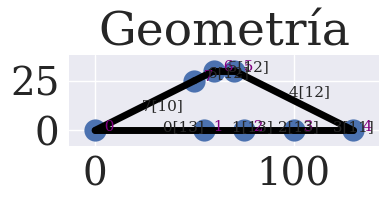

(array([-0.5,  0. ,  0.5,  1. ,  1.5]),
 [Text(0, -0.5, '−0.5'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.5, '0.5'),
  Text(0, 1.0, '1.0'),
  Text(0, 1.5, '1.5')])

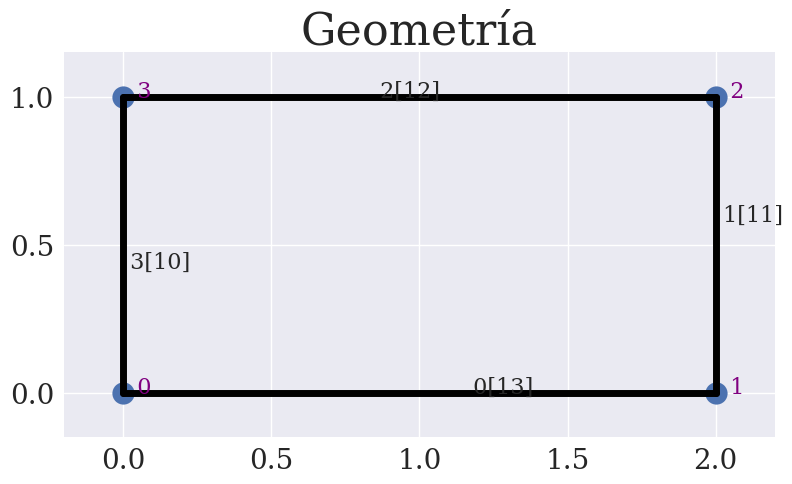

In [11]:
geometria = cfg.Geometry()

# puntos
geometria.point([0,0])      # 0
geometria.point([2,0])     # 1
geometria.point([2,1])     # 2
geometria.point([0,1])    # 3

# líneas
left = 10
right = 11
top = 12
bottom = 13

geometria.line([0,1], marker=bottom)       # 0
geometria.line([1,2], marker=right)       # 1
geometria.line([2,3], marker=top)       # 2
geometria.line([3,0], marker=left)    # 3

# superficies
mat0 = 0
geometria.surface([0,1,2,3], marker=mat0)

# gráfica de la geometría
cfv.figure(fig_size=(16,5))
cfv.title('Geometría', fontdict={"fontsize": 32})
cfv.draw_geometry(geometria, font_size=16, draw_axis=True)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)